# Fine-tune BERT base model for NER

In [2]:
import os
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
import numpy as np
from seqeval.metrics import classification_report, accuracy_score, f1_score
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# model_checkpoint = "EMBEDDIA/litlat-bert" # this is the placeholder model which were used before
model_checkpoint = "neurotechnology/BLKT-RoBERTa-MLM-Stage2-Intermediate"
label_list = []
output_dir = "./bert-ner-model"

train_dir = "../conll_train/"
test_dir = "../conll_test/"


def read_conll(filepath):
    tokens, labels, examples = [], [], []
    with open(filepath, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                if tokens:
                    examples.append({"tokens": tokens, "ner_tags": labels})
                    tokens, labels = [], []
            else:
                parts = line.split()
                if len(parts) != 2:
                    print(f"Skipping malformed line {line_num} in {filepath}: '{line}'")
                    continue
                token, tag = parts
                tokens.append(token)
                labels.append(tag)
        if tokens:
            examples.append({"tokens": tokens, "ner_tags": labels})
    return examples


def load_conll_folder(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".conll"):
            full_path = os.path.join(folder_path, filename)
            examples = read_conll(full_path)
            all_data.extend(examples)
    return all_data


train_data = load_conll_folder(train_dir)
test_data = load_conll_folder(test_dir)

Skipping malformed line 528 in ../conll_train/219207_lt.conll: 'O'
Skipping malformed line 597 in ../conll_train/219207_lt.conll: 'O'
Skipping malformed line 633 in ../conll_train/219207_lt.conll: 'O'
Skipping malformed line 664 in ../conll_train/219207_lt.conll: 'O'
Skipping malformed line 726 in ../conll_train/219207_lt.conll: 'O'
Skipping malformed line 772 in ../conll_train/219207_lt.conll: 'O'
Skipping malformed line 153 in ../conll_train/232365_lt.conll: 'O'
Skipping malformed line 178 in ../conll_train/236364_lt.conll: 'O'
Skipping malformed line 113 in ../conll_train/240051_lt.conll: 'O'
Skipping malformed line 153 in ../conll_train/240452_lt.conll: 'O'
Skipping malformed line 206 in ../conll_train/243782_lt.conll: 'O'
Skipping malformed line 181 in ../conll_train/248092_lt.conll: 'O'
Skipping malformed line 281 in ../conll_train/250746_lt.conll: 'O'
Skipping malformed line 406 in ../conll_train/253710_lt.conll: 'O'
Skipping malformed line 172 in ../conll_train/259843_lt.conll:

In [4]:
# Extract label list
unique_labels = sorted({label for ex in train_data for label in ex["ner_tags"]})
label2id = {l: i for i, l in enumerate(unique_labels)}
id2label = {i: l for l, i in label2id.items()}

In [5]:
# Convert string labels to IDs
for dataset in (train_data, test_data):
    for ex in dataset:
        ex["labels"] = [label2id[tag] for tag in ex["ner_tags"]]

In [6]:
from transformers import AutoTokenizer

# Tokenization and Alignment
# Put the token using !huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [7]:
def tokenize_and_align(example):
    tokenized = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    word_ids = tokenized.word_ids()

    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(example["labels"][word_idx])
        else:
            labels.append(-100)
        previous_word_idx = word_idx

    tokenized["labels"] = labels
    return tokenized


train_dataset = Dataset.from_list(train_data).map(tokenize_and_align, batched=False)
test_dataset = Dataset.from_list(test_data).map(tokenize_and_align, batched=False)

Map: 100%|██████████| 645/645 [00:00<00:00, 2791.02 examples/s]


In [8]:
# Model Setup
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    use_safetensors=True,
)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at neurotechnology/BLKT-RoBERTa-MLM-Stage2-Intermediate and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from transformers import TrainingArguments

# Training Setup
args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir=f"{output_dir}/logs",
    logging_steps=10,
)

In [24]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    matthews_corrcoef,
)

import pandas as pd


# Metric Computation
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    out_preds, out_labels = [], []

    for i in range(batch_size):
        pred_labels = []
        true_labels = []
        for j in range(seq_len):
            if label_ids[i][j] != -100:
                pred_labels.append(id2label[preds[i][j]])
                true_labels.append(id2label[label_ids[i][j]])
        out_preds.append(pred_labels)
        out_labels.append(true_labels)

    return out_preds, out_labels


from collections import defaultdict
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score


def extract_entities(label_seq):
    entities = []
    start, end, label = None, None, None
    for i, tag in enumerate(label_seq):
        if tag.startswith("B-"):
            if label is not None:
                entities.append((start, end, label))
            start = i
            end = i + 1
            label = tag[2:]
        elif tag.startswith("I-") and label == tag[2:]:
            end = i + 1
        else:
            if label is not None:
                entities.append((start, end, label))
                start, end, label = None, None, None
    if label is not None:
        entities.append((start, end, label))
    return entities


def compute_span_matches(pred_spans, true_spans, mode="exact"):
    tp, fp, fn = 0, 0, 0
    used = set()

    for ps in pred_spans:
        matched = False
        for i, ts in enumerate(true_spans):
            if ts[2] != ps[2]:  # labels must match
                continue

            if mode == "exact" and ps == ts:
                matched = True
                used.add(i)
                break

            elif mode == "overlap":
                if max(ps[0], ts[0]) < min(ps[1], ts[1]):
                    matched = True
                    used.add(i)
                    break

            elif mode == "union":
                if ps[0] <= ts[1] and ps[1] >= ts[0]:
                    matched = True
                    used.add(i)
                    break

        if matched:
            tp += 1
        else:
            fp += 1

    fn = len([ts for i, ts in enumerate(true_spans) if i not in used])
    return tp, fp, fn


def compute_metrics(p):
    predictions, labels = p
    preds, refs = align_predictions(predictions, labels)

    # Matthews Correlation Coefficient
    flat_preds = [p for seq in preds for p in seq]
    flat_refs = [r for seq in refs for r in seq]

    mcc = matthews_corrcoef(flat_refs, flat_preds)
    # print(f'Matthews Correlation Coefficient: {mcc}')

    # Confusion Matrix
    cm = confusion_matrix(flat_refs, flat_preds)
    labels = np.unique(flat_refs)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # print("Confusion Matrix (per class):")

    # token-level scores
    token_accuracy = accuracy_score(refs, preds)
    token_precision = precision_score(refs, preds)
    token_recall = recall_score(refs, preds)
    token_f1 = f1_score(refs, preds)

    # span-level scores
    exact_tp, exact_fp, exact_fn = 0, 0, 0
    overlap_tp, overlap_fp, overlap_fn = 0, 0, 0
    union_tp, union_fp, union_fn = 0, 0, 0

    for pred_seq, ref_seq in zip(preds, refs):
        pred_spans = extract_entities(pred_seq)
        ref_spans = extract_entities(ref_seq)

        tp, fp, fn = compute_span_matches(pred_spans, ref_spans, mode="exact")
        exact_tp += tp
        exact_fp += fp
        exact_fn += fn

        tp, fp, fn = compute_span_matches(pred_spans, ref_spans, mode="overlap")
        overlap_tp += tp
        overlap_fp += fp
        overlap_fn += fn

        tp, fp, fn = compute_span_matches(pred_spans, ref_spans, mode="union")
        union_tp += tp
        union_fp += fp
        union_fn += fn

    def safe_div(a, b):
        return a / b if b else 0.0

    def scores(tp, fp, fn):
        precision = safe_div(tp, tp + fp)
        recall = safe_div(tp, tp + fn)
        f1 = (
            safe_div(2 * precision * recall, precision + recall)
            if (precision + recall)
            else 0.0
        )
        return precision, recall, f1

    exact_p, exact_r, exact_f1 = scores(exact_tp, exact_fp, exact_fn)
    overlap_p, overlap_r, overlap_f1 = scores(overlap_tp, overlap_fp, overlap_fn)
    union_p, union_r, union_f1 = scores(union_tp, union_fp, union_fn)

    return {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
        "entity_exact_precision": exact_p,
        "entity_exact_recall": exact_r,
        "entity_exact_f1": exact_f1,
        "entity_overlap_precision": overlap_p,
        "entity_overlap_recall": overlap_r,
        "entity_overlap_f1": overlap_f1,
        "entity_union_precision": union_p,
        "entity_union_recall": union_r,
        "entity_union_f1": union_f1,
        "matthews_coefficient": mcc,
    }

In [25]:
# train the model
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_2766/4158942630.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [26]:
trainer.train()

# Final Evaluation
final_predictions, _, metrics = trainer.predict(test_dataset)
# print("Final Evaluation Metrics:", metrics)

Epoch,Training Loss,Validation Loss,Token Accuracy,Token Precision,Token Recall,Token F1,Entity Exact Precision,Entity Exact Recall,Entity Exact F1,Entity Overlap Precision,Entity Overlap Recall,Entity Overlap F1,Entity Union Precision,Entity Union Recall,Entity Union F1,Matthews Coefficient
1,0.006700,0.067261,0.991153,0.891586,0.901063,0.896299,0.906689,0.897792,0.902219,0.933939,0.921010,0.927429,0.938068,0.917609,0.927726,0.954833
2,0.006700,0.068410,0.991591,0.892196,0.906787,0.899432,0.909992,0.901063,0.905505,0.935590,0.922638,0.929069,0.938068,0.920583,0.929243,0.957140
3,0.000200,0.071594,0.992073,0.904568,0.906787,0.905676,0.920767,0.902698,0.911643,0.944120,0.921824,0.932839,0.946622,0.919773,0.933005,0.959488


In [28]:
# Evaluate on test dataset
test_preds, _, test_metrics = trainer.predict(test_dataset)

# Evaluate on train dataset
train_preds, _, train_metrics = trainer.predict(train_dataset)

# Convert to DataFrames
test_df = pd.DataFrame([test_metrics], index=["Test"])
train_df = pd.DataFrame([train_metrics], index=["Train"])

# Combine into a single summary table
results_df = pd.concat([train_df, test_df])
print("\nEvaluation Metrics (Train vs Test):\n")
print(results_df.T.round(4))


Evaluation Metrics (Train vs Test):

                                  Train      Test
test_loss                        0.0003    0.0716
test_token_accuracy              1.0000    0.9921
test_token_precision             0.9996    0.9046
test_token_recall                0.9994    0.9068
test_token_f1                    0.9995    0.9057
test_entity_exact_precision      0.9996    0.9208
test_entity_exact_recall         0.9994    0.9027
test_entity_exact_f1             0.9995    0.9116
test_entity_overlap_precision    0.9998    0.9441
test_entity_overlap_recall       0.9996    0.9218
test_entity_overlap_f1           0.9997    0.9328
test_entity_union_precision      0.9998    0.9466
test_entity_union_recall         0.9983    0.9198
test_entity_union_f1             0.9990    0.9330
test_matthews_coefficient        0.9999    0.9595
test_runtime                     3.8557    0.9947
test_samples_per_second        649.1740  648.4490
test_steps_per_second           81.1790   81.4330


In [30]:
results_df.T.to_csv("../output/evaluation_metrics_results.csv", index=True)

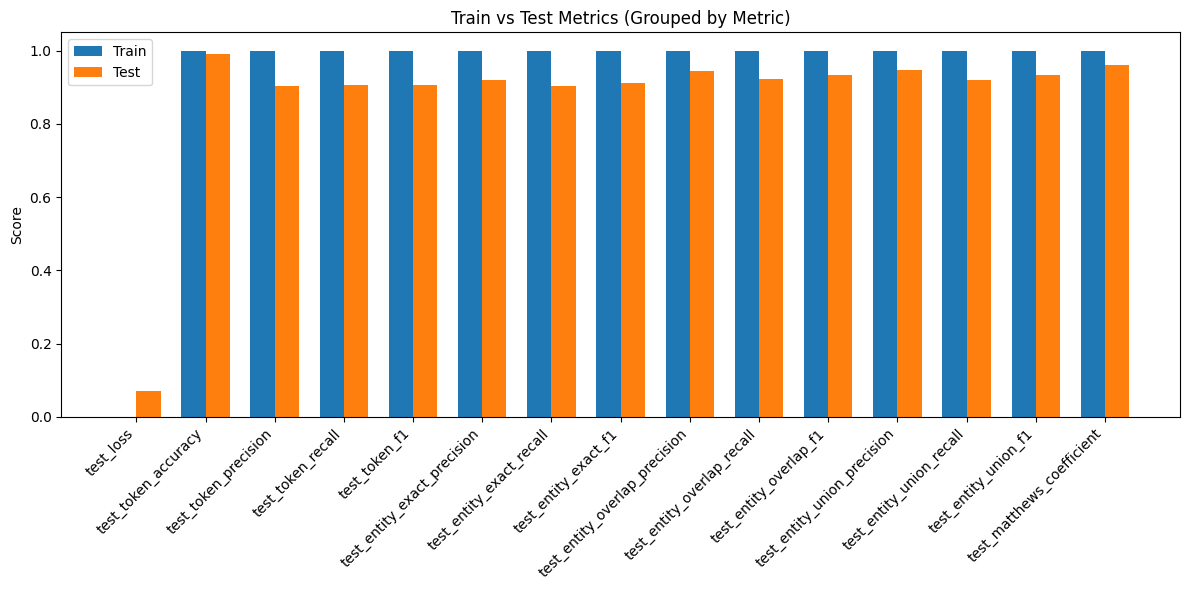

In [33]:
# Reformatting data for grouped bar plot
metrics = results_df.T[:-3].index.tolist()
train_values = results_df.T["Train"][:-3].tolist()
test_values = results_df.T["Test"][:-3].tolist()

x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar([p - width / 2 for p in x], train_values, width, label="Train")
ax.bar([p + width / 2 for p in x], test_values, width, label="Test")

ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("Train vs Test Metrics (Grouped by Metric)")
ax.legend()

plt.tight_layout()
plt.savefig("../output/evaluation_metrics_plot.png", dpi=600)
plt.show()

In [15]:
from transformers import BatchEncoding

# Step 1: Get predictions and aligned labels
predictions, label_ids, _ = trainer.predict(test_dataset)
preds, refs = align_predictions(predictions, label_ids)

# Step 2: Decode tokens for each example
print("\n🔍 Misclassified NER Samples:\n")
max_display = 10
shown = 0

for i in range(len(test_dataset)):
    # Get input_ids for the current example
    input_ids = test_dataset[i]["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Get aligned predicted and true labels
    pred_labels = preds[i]
    true_labels = refs[i]

    # Filter mismatches (skip padding)
    mismatches = [
        (tok, pred, true)
        for tok, pred, true in zip(tokens, pred_labels, true_labels)
        if pred != true and true != "O" and tok not in tokenizer.all_special_tokens
    ]

    if mismatches:
        decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
        print(f"Text: {decoded_text}")
        print("Mismatched Tokens:")
        for tok, pred, true in mismatches:
            print(f"  Token: {tok:15} | Predicted: {pred:10} | True: {true}")
        print("-" * 60)
        shown += 1

    if shown >= max_display:
        break


🔍 Misclassified NER Samples:

Text: GENERALINIO ADVOKATO DONALD KENNEDY BENJO-LOPEZ IŠVADA, pateikta 2019 m. liepos 11 d. (1)
Mismatched Tokens:
  Token: EN              | Predicted: B-PROFESSION | True: B-PER
  Token: ER              | Predicted: I-PROFESSION | True: I-PER
------------------------------------------------------------
Text: Consip SpA ,
Mismatched Tokens:
  Token: ▁Con            | Predicted: I-PER      | True: I-ORG
------------------------------------------------------------
Text: Ministero dell’Economia e delle Finanze ,
Mismatched Tokens:
  Token: ▁Min            | Predicted: I-PROFESSION | True: I-ORG
  Token: ister           | Predicted: I-PROFESSION | True: I-ORG
  Token: o               | Predicted: I-PROFESSION | True: I-ORG
  Token: ▁               | Predicted: I-PROFESSION | True: I-ORG
------------------------------------------------------------
Text: 1. Italijos perkančioji organizacija ( Consip SpA )(2) paskelbė konkursą dėl viešojo tam tikrų paslaugų pir

In [41]:
import transformers, tokenizers

print(transformers.__version__)  # should be ≥ 4.39.0
print(tokenizers.__version__)  # should be ≥ 0.15.0

4.38.0
0.15.2
